In [1224]:
import numpy as np
import sys
sys.path.insert(1,'/home/zhanibek/.local/lib/python2.7/site-packages/cv2')
sys.path.insert(1,'/home/zhanibek/catkin_ws/src/smart_tray/scripts/')
import cv2 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook
import pickle
import pandas as pd

from tqdm.notebook import tqdm

import phri
from phri.utils import *

import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets


from sklearn import linear_model, datasets


In [1225]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions

In [1226]:

def plot_pose(obs, rot = 'orientation'):
    h = 1
    w = 2
    ylim = 1.6
    xlim = 15

    plt.figure(figsize=(20,h*6))


    print obs['traj_type'], obs['motion_type']

    # Position from camera 1
    plt.subplot(h,w,1)
    plt.plot(obs['pose123']['time_steps'], obs['pose123']['position'], '.', alpha=1)
    plt.legend(['x','y','z'])
    plt.gca().set_title('Position %s %s %s'%(obs['pose123']['frame_id'],obs['traj_type'], obs['motion_type']))
    plt.grid()

    plt.ylim(-1.5, 3.2)
    plt.xlim(0, xlim)


    plt.subplot(h,w,2)
    plt.plot(obs['pose123']['time_steps'], obs['pose123'][rot], '.', alpha=1)
    plt.legend(['x','y','z', 'angle'])
    plt.gca().set_title('Orientation %s %s %s'%(obs['pose123']['frame_id'],obs['traj_type'], obs['motion_type']))
    plt.grid()

    plt.xlim(0, xlim)
    plt.ylim(-2*np.pi, 2*np.pi)
    
def plot_all_clean(obs, rot = 'orientation'):
    
    h = 5
    w = 2
    ylim = 1.5
    xlim = 15

    plt.figure(figsize=(20,h*6))

    print obs['traj_type'], obs['motion_type']

    # RFT1 1
    plt.subplot(h,w,1)
    plt.plot(obs['rft1']['time_steps'], obs['rft1']['force'], )
    plt.legend(['x','y','z'])
    plt.gca().set_title('RFT 1 %s %s %s'%(obs['rft1']['frame_id'], obs['traj_type'], obs['motion_type']))
    plt.grid()

    # plt.ylim(-ylim, ylim)
    plt.xlim(0, xlim)


    plt.subplot(h,w,2)
    plt.plot(obs['rft1']['time_steps'], obs['rft1']['torque'])
    plt.legend(['x','y','z'])
    plt.gca().set_title('RFT 1 %s %s %s'%(obs['rft1']['frame_id'], obs['traj_type'], obs['motion_type']))
    plt.grid()

    plt.xlim(0, xlim)


    # RFT 2
    plt.subplot(h,w,3)
    plt.plot(obs['rft2']['time_steps'], obs['rft2']['force'])
    plt.legend(['x','y','z'])
    plt.gca().set_title('RFT 2 %s %s %s'%(obs['rft2']['frame_id'], obs['traj_type'], obs['motion_type']))
    plt.grid()

    # plt.ylim(-ylim, ylim)
    plt.xlim(0, xlim)


    plt.subplot(h,w,4)
    plt.plot(obs['rft2']['time_steps'], obs['rft2']['torque'])
    plt.legend(['x','y','z'])
    plt.gca().set_title('RFT 2 %s %s %s'%(obs['rft2']['frame_id'], obs['traj_type'], obs['motion_type']))
    plt.grid()

    plt.xlim(0, xlim)


    # Position
    plt.subplot(h,w,5)
    plt.plot(obs['pose123']['time_steps'], obs['pose123']['position'], '.')
    plt.legend(['x','y','z'])
    plt.gca().set_title('Position %s %s %s'%(obs['pose123']['frame_id'], obs['traj_type'], obs['motion_type']))
    plt.grid()

    plt.ylim(-1, 3)
    plt.xlim(0, xlim)

    plt.subplot(h,w,6)
    plt.plot(obs['pose123']['time_steps'], obs['pose123'][rot],'.')
    plt.legend(['x','y','z', 'angle'])
    plt.gca().set_title('Position %s %s %s'%(obs['pose123']['frame_id'], obs['traj_type'], obs['motion_type']))
    plt.grid()

    plt.xlim(0, xlim)


    # IMU
    plt.subplot(h,w,7)
    plt.plot(obs['imu']['time_steps'], obs['imu']['accel'])
    plt.legend(['x','y','z'])
    plt.gca().set_title('Accel %s %s %s'%(obs['imu']['frame_id'], obs['traj_type'], obs['motion_type']))
    plt.grid()

#     plt.ylim(-ylim, ylim)
    plt.xlim(0, xlim)

    plt.subplot(h,w,8)
    plt.plot(obs['imu']['time_steps'], obs['imu']['gyro'])
    plt.legend(['x','y','z'])
    plt.gca().set_title('Gyro %s %s %s'%(obs['imu']['frame_id'], obs['traj_type'], obs['motion_type']))
    plt.grid()

    plt.xlim(0, xlim)


    # Position from camera 3
    plt.subplot(h,w,9)
    plt.plot(obs['imu']['time_steps'], obs['imu']['mag'])
    plt.legend(['x','y','z'])
    plt.gca().set_title('Mag %s %s %s'%(obs['imu']['frame_id'], obs['traj_type'], obs['motion_type']))
    plt.grid()


## Constants

In [1383]:
meta_data_paths = [
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/koh_sanket/trial_0/koh_sanket_trial_0_2020-10-11-20-48-27_meta_data_v2.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/koh_zhanibek/trial_0/koh_zhanibek_trial_0_2020-10-11-21-19-07_meta_data_v2.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/sanket_vignesh/trial_0/trial_0_2020-10-12-14-47-43_meta_data_v2.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/sanket_vignesh/trial_1/trial_1_2020-10-12-14-51-53_meta_data_v2.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/zhanibek_sanket/trial_0/trial_0_2020-10-12-15-02-32_meta_data_v2.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/zhanibek_vignesh/trial_0/trial_0_2020-10-12-14-57-11_meta_data_v2.pkl'
]

ann_paths = ['/home/zhanibek/codes/phhi_data_analysis/data/annotation/annotation - KOH_Sanket.csv',
             '/home/zhanibek/codes/phhi_data_analysis/data/annotation/annotation - KOH_Zhanibek.csv',
            '/home/zhanibek/codes/phhi_data_analysis/data/annotation/annotation - Sanket_Vignesh_1.csv',
            '/home/zhanibek/codes/phhi_data_analysis/data/annotation/annotation - Sanket_Vignesh_2.csv',
            '/home/zhanibek/codes/phhi_data_analysis/data/annotation/annotation - Zhanibek_Sanket.csv',
            '/home/zhanibek/codes/phhi_data_analysis/data/annotation/annotation - Zhanibek_Vignesh.csv']

imu_delay_const = 52345.383253
imu_delays = np.array([0,0,0,0,0,0])
imu_delays[[2,3,4,5]] = imu_delay_const


ipath = 4

meta_data_path = meta_data_paths[ipath]
# ft_data_path = ft_data_paths[ipath]
ann_path = ann_paths[ipath]
trial_pair = os.path.basename(ann_path).split('- ')[-1].split('.')[0]
imu_delay = imu_delays[ipath]

In [1384]:
meta_data = pickle.load(open(meta_data_path))

In [1385]:
# all_observations = pickle.load(open('segmented_trials.pkl'))

In [1386]:
ann_df0 = pd.read_csv(ann_path)
ann_df0.columns = ['obs_num', 'trajectory_type', 'motion_type', 'negotiation', 't0_cam_1_seq',
                  't0_sec', 'tf_cam_1_seq', 'tf_sec', 'duration', 't0_precise','tf_precise',
                  'duration_precise']

time_offset = float(ann_df0['t0_sec'][0])*1000
time_offset

1602530000.0

In [1387]:
ann_df = ann_df0[5:]
ann_df

,obs_num,trajectory_type,motion_type,negotiation,t0_cam_1_seq,t0_sec,tf_cam_1_seq,tf_sec,duration,t0_precise,tf_precise,duration_precise
5,1.0,AB1,parallel,NaN,54963,2979,55169,2985,6,2979.387,2986.06,6.673
6,2.0,BA1,parallel,NaN,55248,2988,55489,2995,7,2988.294,2998.861,10.567
7,3.0,AB2,parallel,NaN,55542,2997,55789,3004,7,2997.583,3004.784,7.201
8,4.0,BA1,parallel,NaN,55906,3007,56169,3015,8,3007.541,3016.596,9.055
9,5.0,AB2,parallel,NaN,56281,3019,56498,3025,6,3019.177,3026.204,7.027
10,6.0,BA2,serial,NaN,56728,3032,56936,3039,7,3032.15,3038.864,6.714
11,7.0,AB2,parallel,NaN,57021,3041,57266,3050,9,3042.017,3049.335,7.318
12,8.0,BA1,serial,NaN,57374,3052,57664,3062,10,3052.616,3062.087,9.471
13,9.0,AB2,parallel,NaN,58037,3072,58267,3080,8,3073.182,3080.731,7.549
14,10.0,BA2,parallel,NaN,58422,3085,58649,3092,7,3084.849,3092.802,7.953


### Transformation Constants

In [1388]:
# gAS - A to grf
grfA = np.array(
    [[-1, 0, 0, 1.42],
     [0, -1, 0, 0.12],
     [0,  0, 1, 0    ], 
     [0,  0, 0, 1    ]])
# gBS - B to grf
grfB = np.array(
    [[1, 0, 0, 1.27],
     [0, 1, 0, -0.12],
     [0, 0, 1, 0    ], 
     [0, 0, 0, 1    ]])

In [1389]:
def read_rft(tt0,ttf, temp_df):
    
    cut = temp_df.time_stamp.apply(lambda x: x>=tt0 and x<=ttf)
    temp = temp_df[cut]

    force =  dict(temp)['force'].to_numpy()
    force = np.array([[f[0],f[1],f[2]] for f in force])

    torque =  dict(temp)['torque'].to_numpy()
    torque = np.array([[f[0],f[1],f[2]] for f in torque])
    
    tsteps = dict(temp)['time_stamp'].to_numpy()
    tsteps -= tt0
    frame_id = temp_df.frame_id.iloc[0]
    
    new_force = np.zeros(force.shape)
    new_torque = new_force.copy()
    # Convert to Tray Reference Frame
    # Sensor 1
    if frame_id =='C00300119':        
        new_force[:,0] = force[:,2]
        new_force[:,1] = force[:,0]
        new_force[:,2] = force[:,1]
        
        new_torque[:,0] = torque[:,2]
        new_torque[:,1] = torque[:,0]
        new_torque[:,2] = torque[:,1]
    # Sensor 2    
    elif frame_id =='C00300122':
        new_force[:,0] = -force[:,2]
        new_force[:,1] = -force[:,0]
        new_force[:,2] =  force[:,1]
        
        new_torque[:,0] = -torque[:,2]
        new_torque[:,1] = -torque[:,0]
        new_torque[:,2] =  torque[:,1]
        
    res = {'time_steps': tsteps, 'force': new_force, 'torque':new_torque, 'frame_id':frame_id }
    
    return res

def read_imu(tt0, ttf, temp_df):

    cut = imu_df.time_stamp.apply(lambda x: x>=tt0 and x<=ttf)
    temp = imu_df[cut]

    accel =  dict(temp)['accel'].to_numpy()
    accel = np.array([[f[0],f[1],f[2]] for f in accel])

    gyro =  dict(temp)['gyro'].to_numpy()
    gyro = np.array([[f[0],f[1],f[2]] for f in gyro])

    mag =  dict(temp)['mag'].to_numpy()
    mag = np.array([[f[0],f[1],f[2]] for f in mag])
    tsteps = dict(temp)['time_stamp'].to_numpy()
    tsteps -= tt0
    
    # Transform from Sensor Coordinate frame to Tray Coordinates
    new_accel = np.zeros(accel.shape)
    new_gyro = new_accel.copy()
    new_mag = new_gyro.copy()
    
    new_accel[:,0] = accel[:,0]
    new_accel[:,1] = -accel[:,1]
    new_accel[:,2] = -accel[:,2]

    new_mag[:,0] = mag[:,0]
    new_mag[:,1] = -mag[:,1]
    new_mag[:,2] = -mag[:,2]
    
    new_gyro[:,0] = gyro[:,0]
    new_gyro[:,1] = -gyro[:,1]
    new_gyro[:,2] = -gyro[:,2]
    
    res = {'time_steps': tsteps, 'accel': new_accel, 'gyro':new_gyro, 'mag':new_mag, 'frame_id': temp.frame_id.iloc[0]}

    return res


def read_pose(tt0, ttf, pose_df):

    cut = pose_df.time_stamp.apply(lambda x: x>=tt0 and x<=ttf)
    temp = pose_df[cut]

    position =  dict(temp)['position'].to_numpy()
    position = np.array([[f[0],f[1],f[2]] if not np.isnan(f).any() else [np.nan,np.nan,np.nan] for f in position ])

    quat =  dict(temp)['quaternion'].to_numpy()
    quat = np.array([[f[0],f[1],f[2],f[3]] if not np.isnan(f).any() else [np.nan,np.nan,np.nan,np.nan] for f in quat])

    tsteps = dict(temp)['time_stamp'].to_numpy()
    tsteps -= tt0
    
        
    res = {'time_steps': tsteps, 'position': position, 'quaternion':quat, 'frame_id': pose_df.frame_id.iloc[0]}

    return res


def merge_offline_pos(pos, pos_off,txt='_merged'):
    if len(pos['position'])==0 and np.isnan(pos_off['position']).all():
        return {'time_steps': [], 'position': [], 'quaternion':[], 'frame_id': pos['frame_id']+txt}
    elif len(pos['position'])==0:
        res = {'time_steps': pos_off['time_steps'], 
               'position': pos_off['position'], 
               'quaternion': pos_off['quaternion'], 
               'frame_id': pos_off['frame_id']+txt}
        return res
    elif len(pos_off['position'])==0:
        res = {'time_steps': pos['time_steps'], 
               'position': pos['position'], 
               'quaternion': pos['quaternion'], 
               'frame_id': pos['frame_id']+txt}
        return res
    
    res = {}
    tt = np.concatenate((pos['time_steps'], pos_off['time_steps']))
    pp = np.concatenate((pos['position'], pos_off['position']))
    qq = np.concatenate((pos['quaternion'], pos_off['quaternion']))

    # drop duplicate values
    _, indx = np.unique(tt, return_index=True)

    tt = tt[indx]
    pp = pp[indx]
    qq = qq[indx]
    # sort once more timewise
    sind = np.argsort(tt)
    tt = tt[sind]
    pp = pp[sind]
    qq = qq[sind]
    
    res = {'time_steps': tt, 'position': pp, 'quaternion':qq, 'frame_id': pos['frame_id']+txt}
    return res

def filter_outliers(pose123):
    orientation = pose123['orientation']
    position = pose123['position']
    t = pose123['time_steps']
    
    m = 2.
    fence_orient = np.quantile(orientation, [0.25, 0.75], axis=0)
    iqr = fence_orient[1]-fence_orient[0]
    fence_orient[0] -= m*iqr
    fence_orient[1] += m*iqr

    fence_pos = np.quantile(position, [0.25, 0.75], axis=0)
    iqr = fence_pos[1]-fence_pos[0]
    fence_pos[0] -= m*iqr
    fence_pos[1] += m*iqr
    
    outlier_mask = ((orientation > fence_orient[1]) + 
                (orientation < fence_orient[0])).any(axis=1)
    outlier_mask += ((position > fence_pos[1]) + 
                     (position < fence_pos[0])).any(axis=1)
    inlier_mask = ~outlier_mask
    
    pose123['time_steps'] = pose123['time_steps'][inlier_mask]
    pose123['position'] = pose123['position'][inlier_mask]
    pose123['orientation'] = pose123['orientation'][inlier_mask]
    
    return pose123


def enforce_angle_range(pos123):
    
    orientation = pos123['orientation']
    # Connect discontinued angle signals. It happens when it exceeds the boundary of [-pi, pi]
    angle = orientation[:,3]
    angle_diff = np.diff(angle)
    N = angle.shape[0]
    thresh = 5.5 #-np.pi/10
    num_iter = 0
    prev_i=0
    while (abs(angle_diff) >= thresh).any() and num_iter<=10:
        disc_inds = np.arange(N-1)[abs(angle_diff)>=thresh]
        ii = disc_inds[0]
        if ii <= prev_i and disc_inds.shape[0]>1:
            ii = disc_inds[1]
        # offset by 2pi    
        si = 1 if angle[:ii+1].mean()>angle[ii+1:-1].mean() else -1
        angle[ii+1:-1] += 2*np.pi*si

        angle_diff = np.diff(angle)        
        num_iter+=1 
        prev_i = ii
    
#     print num_iter
    pos123['orientation'] = orientation
    return pos123

def transform2grfAB(pos123, traj_type):
    
    # Drop nans
    position = pos123['position'].copy()
    quaternion = pos123['quaternion'].copy()
    t = pos123['time_steps'].copy()
    
    # Drop old values
    pos123.pop('position', None)
    pos123.pop('time_steps', None)
    pos123.pop('quaternion', None)

    idx = ~np.isnan(position[:,0])
    
    position = position[idx,:]
    quaternion = quaternion[idx,:]
    t = t[idx]
    
    orientation = np.zeros(quaternion.shape)
    position_new = np.zeros(position.shape)
    for ind in range(t.shape[0]):
        pos = position[ind, :]
        quat = quaternion[ind, :]
        
        gt = g_from_pose({'position': pos, 'orientation':quat})
        # fix left handed coordinate reference frame bug from aruco
        R = gt[:3,:3]
        if np.sign(np.linalg.det(R))==-1:
            gt[:,1] = -gt[:,1]
            print('Left handed Frame is found!')
            
        if 'AB' in traj_type:
            g_new = np.matmul(grfA, gt)
            
        elif 'BA' in traj_type:
            g_new = np.matmul(grfB, gt)
        

        pose_new = pose_from_g(g_new, rotation='axis-angle', zup=True)
        position_new[ind,:] = pose_new['position']
        orientation[ind,:] = pose_new['orientation']
    
#     # make sure that angle starts within [-pi, pi]
#     while abs(orientation[0:10,-1].mean()) > np.pi:
#         if orientation[0:10,-1].mean() > np.pi/2+np.pi/10:
#             orientation[:,-1] -= 2*np.pi
#         elif orientation[0:10,-1].mean() < -(np.pi/2+np.pi/10):
#             orientation[:,-1] += 2*np.pi
    
    
    pos123['position'] = position_new
    pos123['orientation'] = orientation
    pos123['time_steps'] = t
    
    if traj_type=='BA1':
        traj_type = 'AB2'
    elif traj_type=='BA2':
        traj_type = 'AB1'
        
    return pos123, traj_type


In [1393]:
total_obs = ann_df.shape[0]
observations = []
rft1_df = meta_data['/RFT_FORCE']
rft2_df = meta_data['/RFT_FORCE_2']
imu_df = meta_data['/imu_data'].copy()
imu_df.time_stamp+=imu_delay

pose1_df = meta_data['/cam1_tray_grf']
pose1_off_df = meta_data['camera_1_grf_offline']

pose2_df = meta_data['/cam2_tray_grf']
pose2_off_df = meta_data['camera_2_grf_offline']

pose3_df = meta_data['/cam3_tray_grf']
pose3_off_df = meta_data['camera_3_grf_offline']

for obs_num in tqdm(range(1,total_obs+1)):

    tt0 = float(ann_df.t0_precise[ann_df.obs_num==obs_num])+time_offset
    ttf = float(ann_df.tf_precise[ann_df.obs_num==obs_num])+time_offset
    
    rft1 = read_rft(tt0,ttf, rft1_df)
    rft2 = read_rft(tt0,ttf, rft2_df)
    
    imu = read_imu(tt0, ttf, imu_df)
    
    pose1_grf = read_pose(tt0, ttf, pose1_df)
    pose1_off_grf = read_pose(tt0, ttf, pose1_off_df)
    pose1_merged = merge_offline_pos(pose1_grf, pose1_off_grf)
    
    pose2_grf = read_pose(tt0, ttf, pose2_df)
    pose2_off_grf = read_pose(tt0, ttf, pose2_off_df)
    pose2_merged = merge_offline_pos(pose2_grf, pose2_off_grf)
    
    pose3_grf = read_pose(tt0, ttf, pose3_df)
    pose3_off_grf = read_pose(tt0, ttf, pose3_off_df)
    pose3_merged = merge_offline_pos(pose3_grf, pose3_off_grf)
    
    
    pos123 = merge_offline_pos(pose1_merged, pose2_merged, txt='123')
    pos123 = merge_offline_pos(pos123, pose3_merged, txt='123')
    
    traj_type = ann_df.trajectory_type[ann_df.obs_num==obs_num].iloc[0]
    motion_type = ann_df.motion_type[ann_df.obs_num==obs_num].iloc[0]
    
    pos123, traj_type = transform2grfAB(pos123, traj_type)
    pos123 = enforce_angle_range(pos123)
    
#     pos123 = filter_outliers(pos123)
    
    pos123 = enforce_angle_range(pos123)
    
    obs = {'rft1': rft1, 'rft2': rft2, 'imu':imu, 
#            'pose1_grf': pose1_grf, 'pose2_grf': pose2_grf, 'pose3_grf': pose3_grf,
#            'pose1_merged':pose1_merged, 'pose2_merged':pose2_merged, 'pose3_merged':pose3_merged,
           'pose123':pos123,
#            'pose1_off_grf': pose1_off_grf, 'pose2_off_grf': pose2_off_grf, 'pose3_off_grf': pose3_off_grf,
           'traj_type':traj_type, 'motion_type': motion_type, 'obs_id':trial_pair+'_'+str(obs_num)}
    
    
    observations.append(obs)

/home/zhanibek/.local/lib/python2.7/site-packages/ipykernel_launcher.py:181: RuntimeWarning:

Mean of empty slice.



### Draw 123 merged position

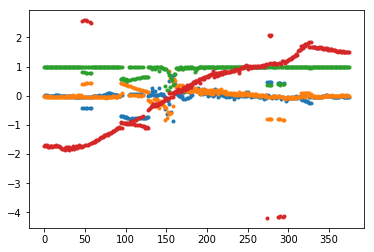

In [1394]:
plt.plot(observations[7]['pose123']['orientation'],'.')

AB1 parallel
AB2 parallel
AB2 parallel
AB2 parallel
AB2 parallel
AB1 serial
AB2 parallel
AB2 serial
AB2 parallel
AB1 parallel
AB2 serial
AB1 parallel
AB1 serial
AB1 parallel
AB2 serial
AB2 parallel
AB2 parallel
AB2 parallel
AB2 parallel
AB2 parallel
AB2 parallel
AB1 parallel


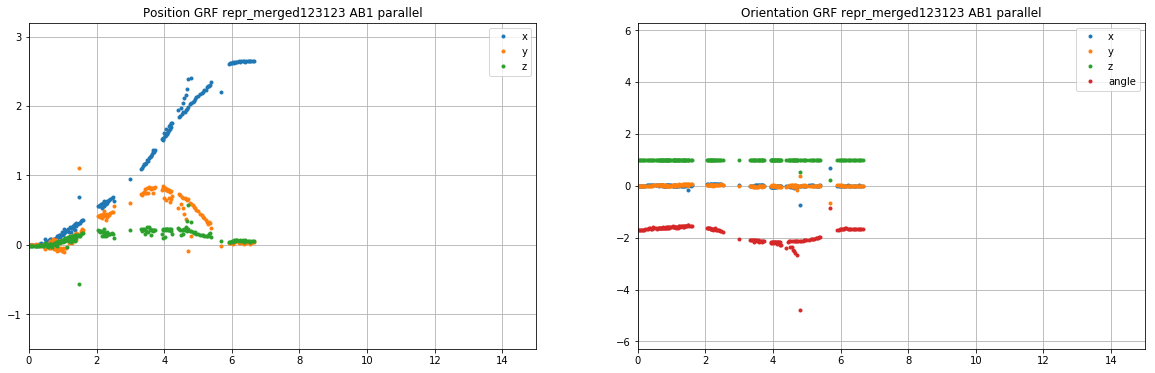

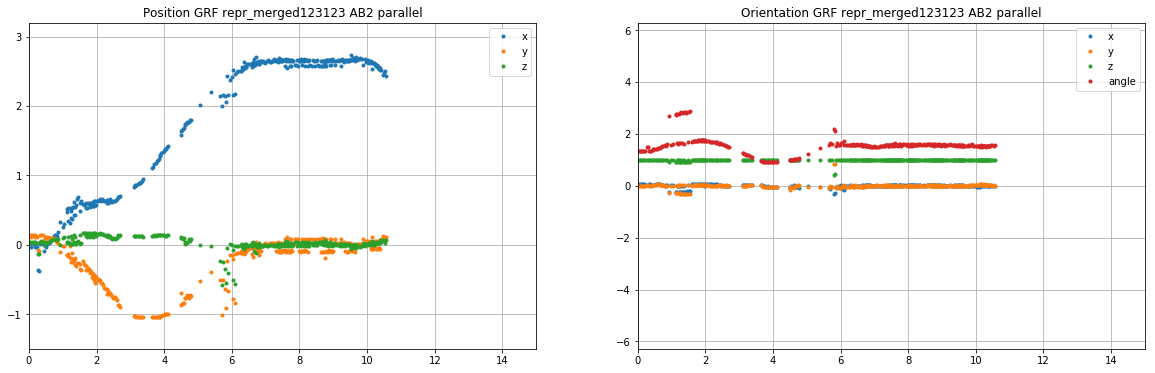

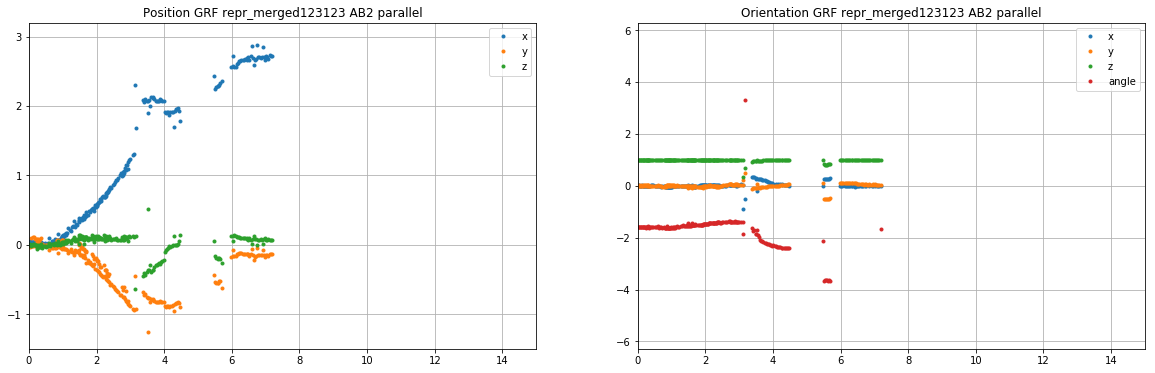

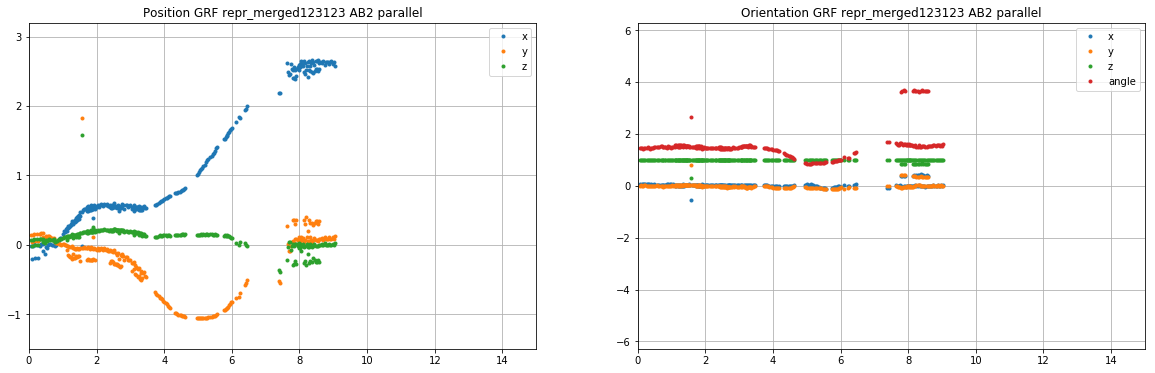

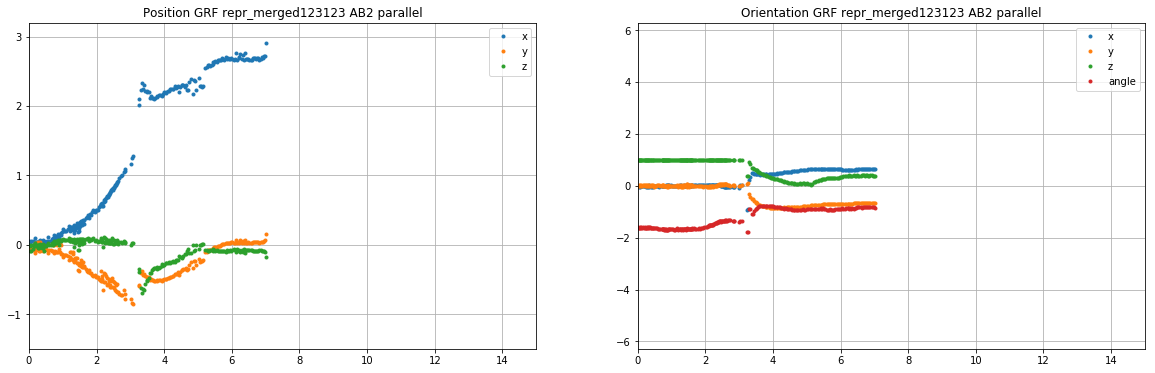

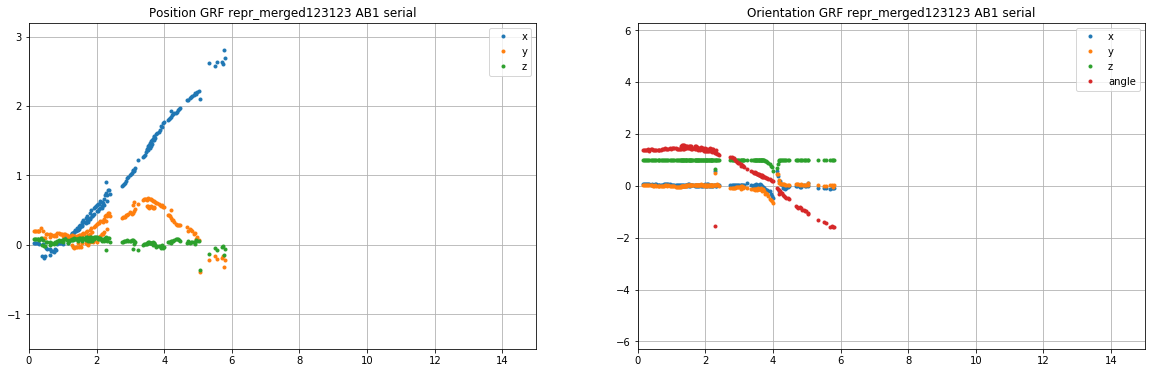

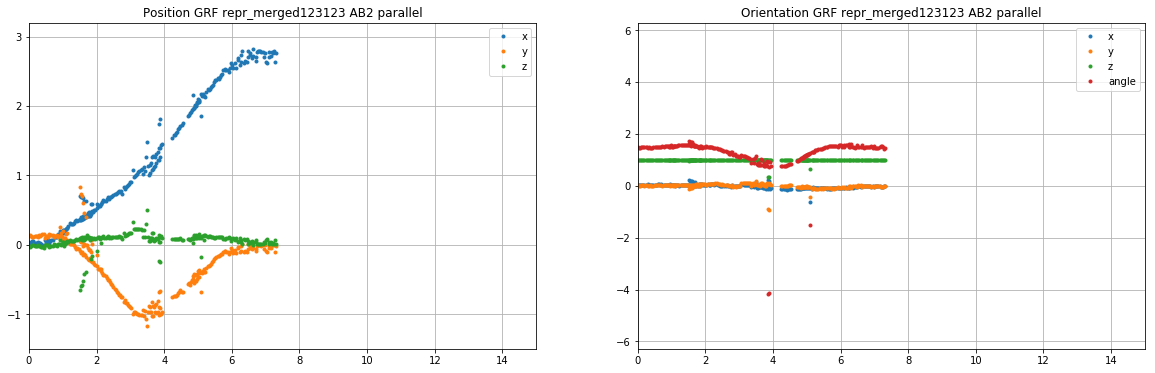

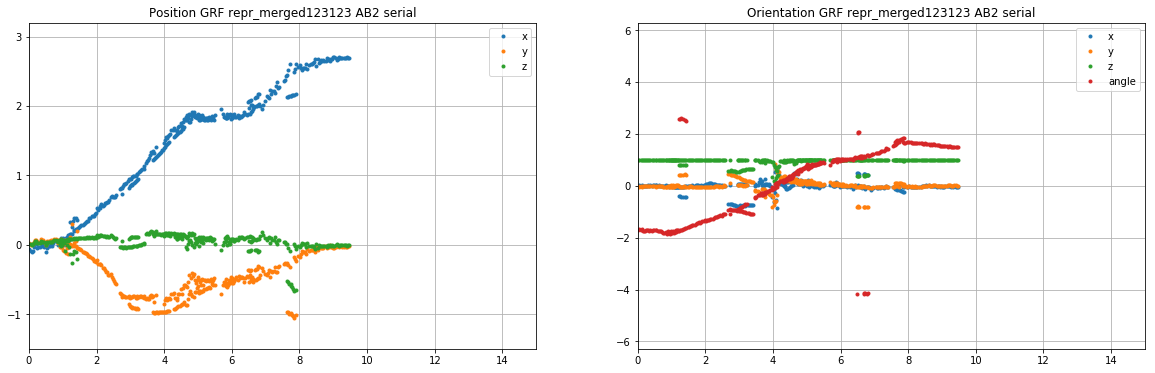

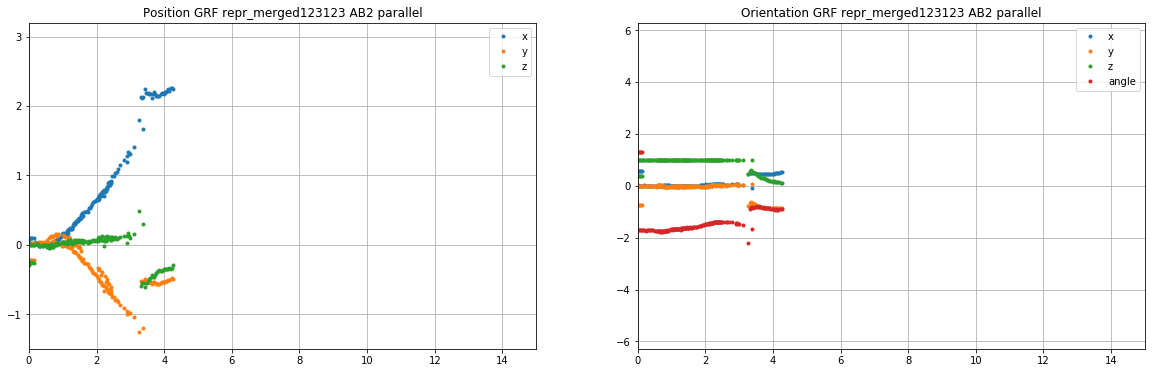

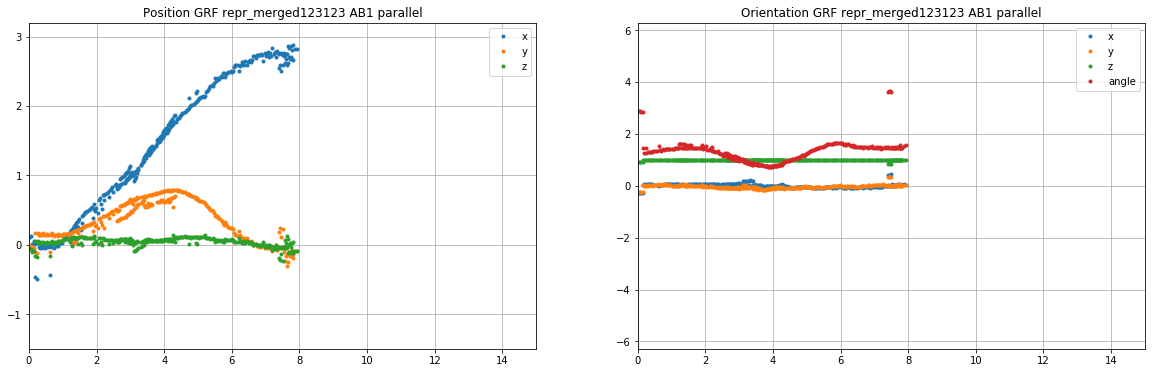

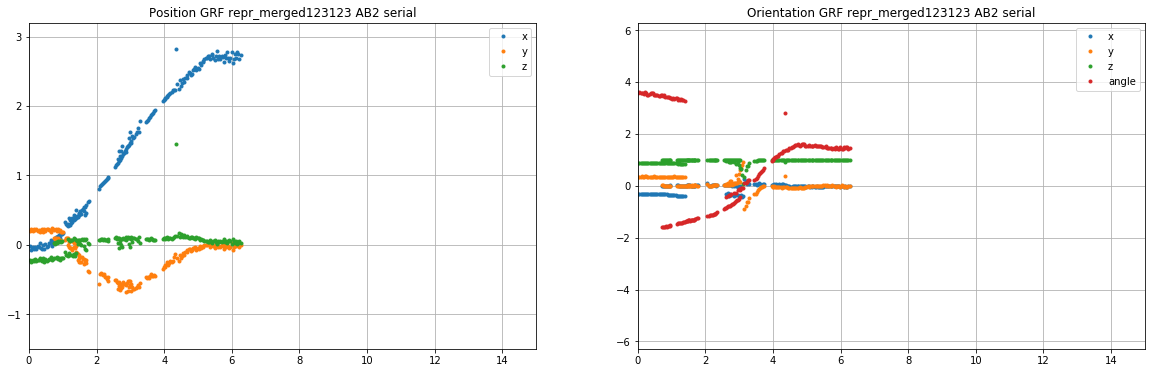

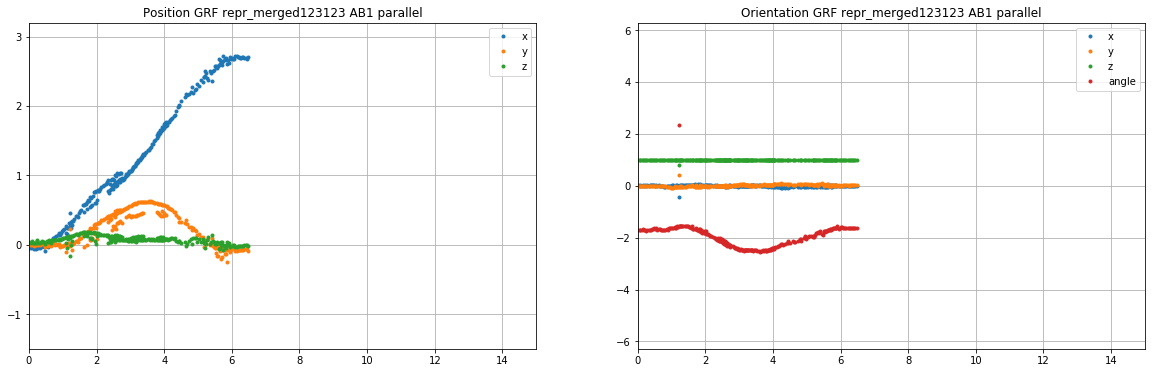

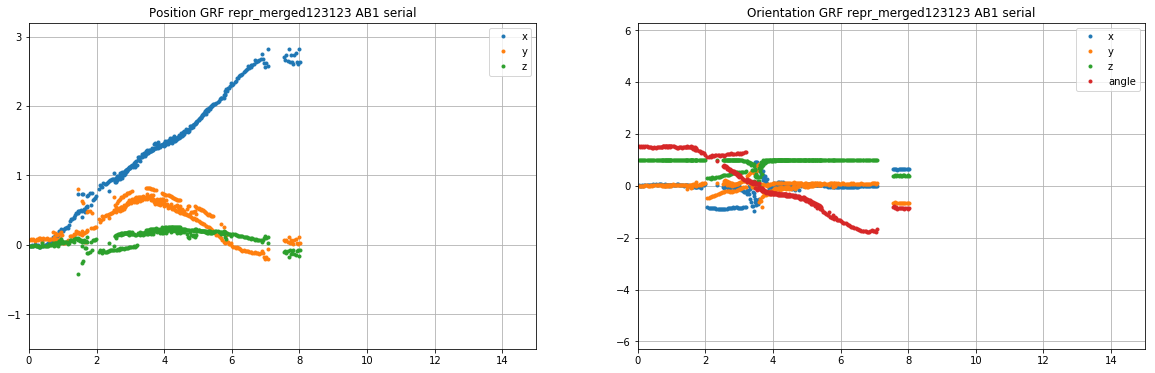

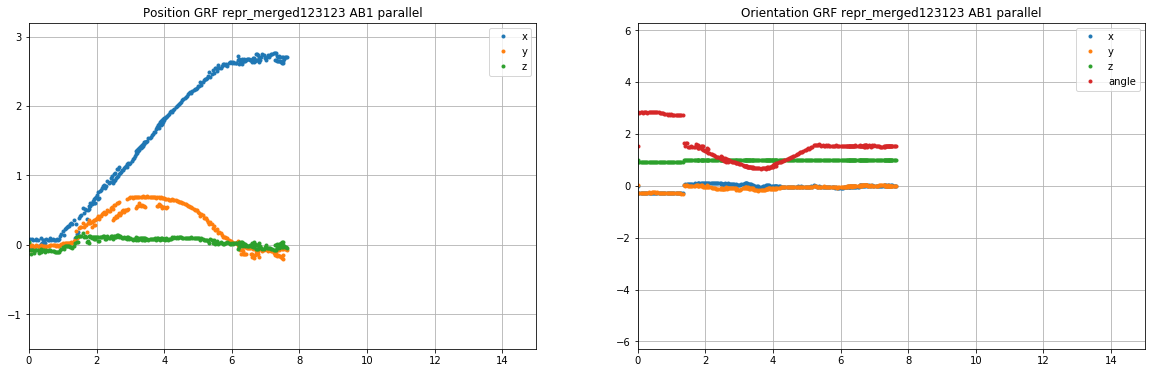

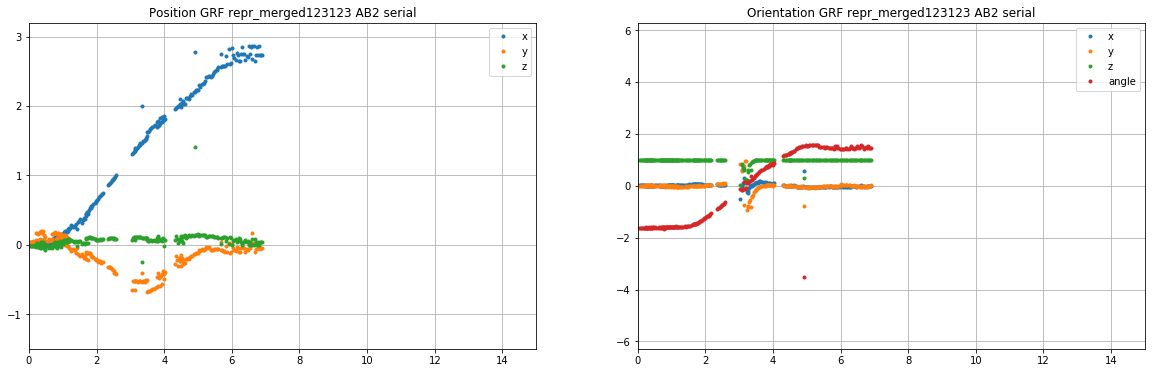

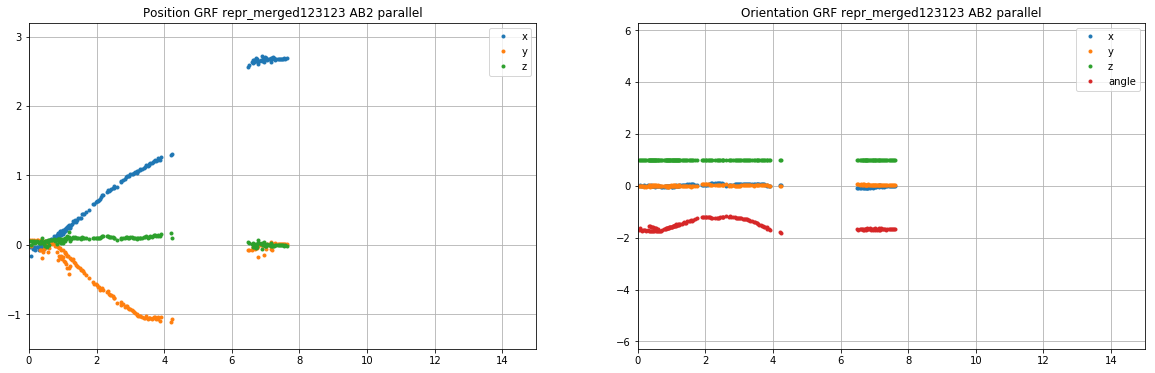

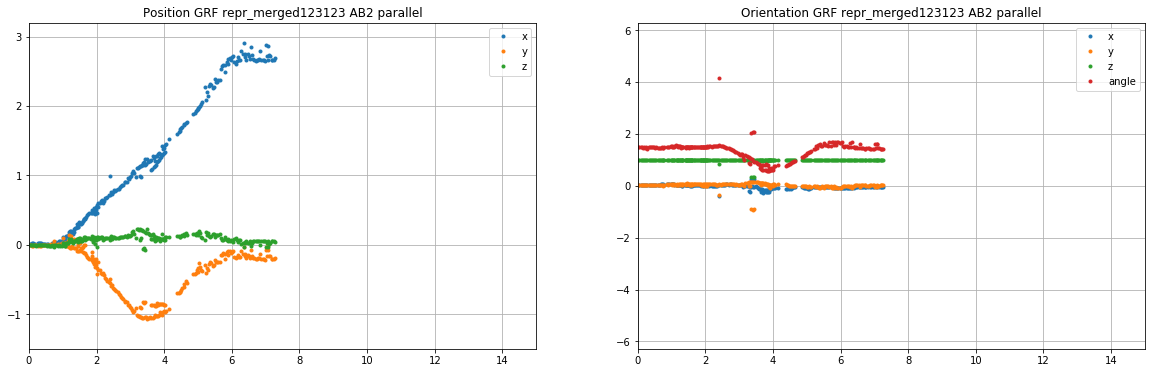

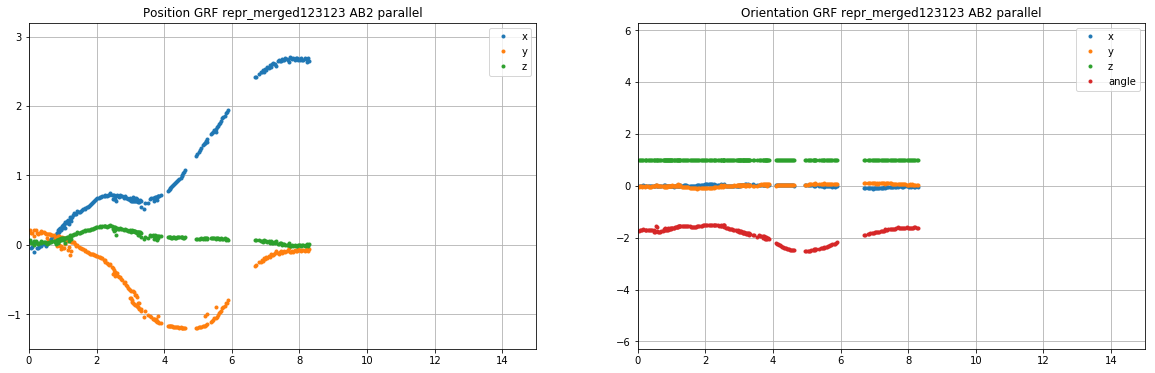

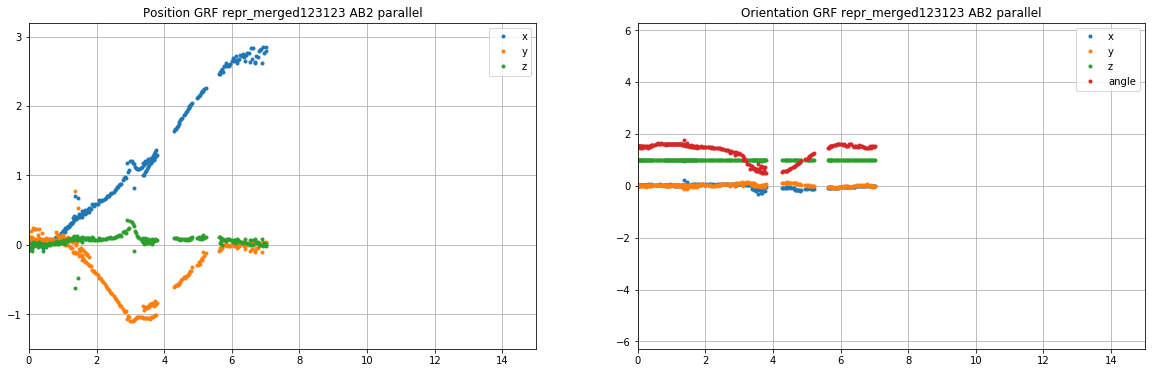

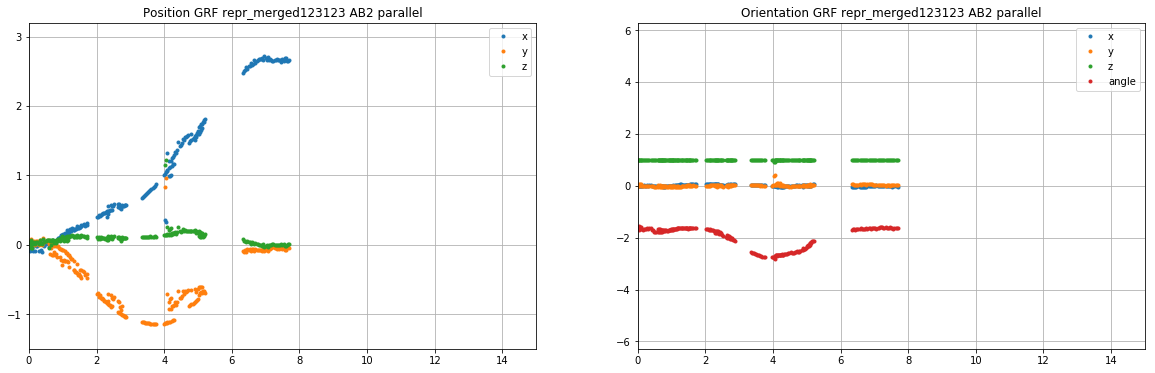

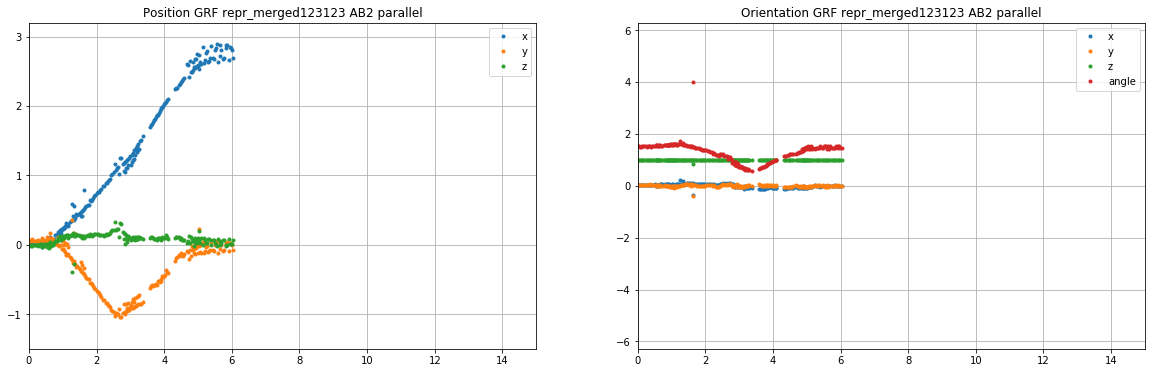

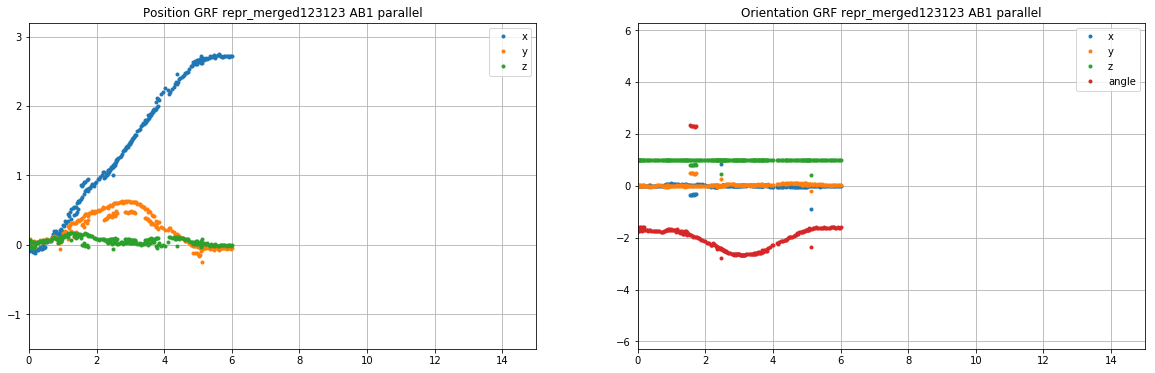

In [1395]:
for i in range(len(observations)):
    plot_pose(observations[i])

### Kalman Filter on position x

Average Frequency of the position data:  29.762276119888945
Average Frequency of the IMU data:  77.43602098306074


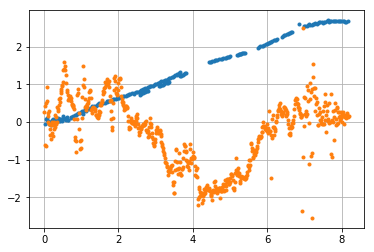

In [1350]:
obs = observations[7]

orientation = obs['pose123']['orientation'].copy()
position = obs['pose123']['position'].copy()
tpos = obs['pose123']['time_steps']
freq_pos = tpos.shape[0]/tpos[-1]

imu = obs['imu']
timu = imu['time_steps']
accel = imu['accel']
freq_imu = timu.shape[0]/timu[-1]

print 'Average Frequency of the position data: ', freq_pos
print 'Average Frequency of the IMU data: ', freq_imu

plt.plot(tpos,position[:,0], '.')
plt.grid()

plt.plot(timu,accel[:,0],'.')

#### Interpolate acceleration to have same time steps with position data

In [1351]:
accel_aligned = np.zeros(position.shape)
accel_aligned[:,0] = np.interp(tpos, timu, accel[:,0])
accel_aligned[:,1] = np.interp(tpos, timu, accel[:,1])
accel_aligned[:,2] = np.interp(tpos, timu, accel[:,2])

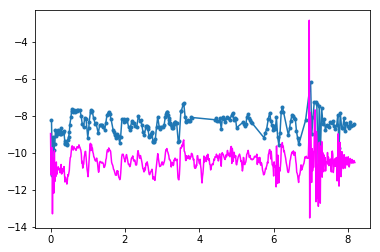

In [1352]:
# Corresponding plot
plt.plot(tpos,accel_aligned[:,2]+2, '.-')
plt.plot(timu, accel[:,2],'-', color='magenta')

#### Transform acceleration from Boday frame to Spatial Frame

In [1353]:

accel_grf = np.zeros(accel_aligned.shape)
for i, orient in enumerate(orientation):
    rot_mat = rotation_matrix(orient[-1], orient[:3])[:3,:3]
    accel_grf[i,:] = np.matmul(rot_mat, accel_aligned[i])

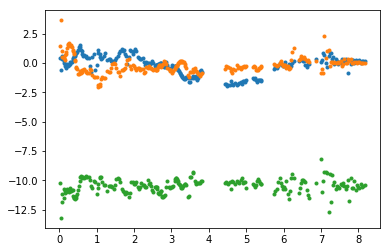

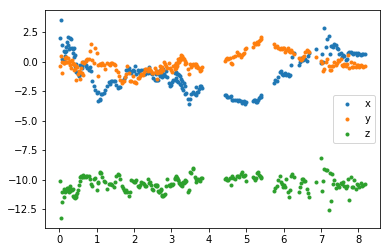

In [1354]:
# Corresponding plot
plt.plot(tpos,accel_aligned, '.')

plt.figure()
plt.plot(tpos, accel_grf,'.')
plt.legend(['x','y','z'])

In [1355]:
'''
State vector:
    x = [pos, vel, accel]
    x[t] = A*x[t-1]+w
Measurement:
    z = [pos, acc]
    
A = np.array(
    [[],
     [],
     []])
'''

A = lambda i: np.array(
    [[1,tpos[i]-tpos[i-1], (tpos[i]-tpos[i-1])**2],
     [0, 1, tpos[i]-tpos[i-1]],
     [0, 0, 0]])

H = np.array(
    [[1,0,0],
     [0,0,1]])
B = np.array([0, 0, 1])
g_off = np.array([0,0,-9.86])

In [1359]:
N = tpos.shape[0]
z_meas = np.vstack((position[:,1], accel_grf[:,1])).transpose()
x_est = np.zeros((N,3))
x_est[0,[0,2]] = z_meas[0]

# Initial Error
P = np.array(
    [[0.0001, 0, 0],
     [0, 0.01, 0],
     [0, 0, 0.01]])

# Process Noise
Q = np.array(
    [[0.001, 0, 0],
     [0, 10., .0],
     [0, 0, 10.]])

# Measurement Noise
R = np.array(
    [[1., 0],
     [0, 1.]])

for i in range(1,N):
    # Predict
    x_ = np.matmul(A(i), x_est[i-1]) + B*z_meas[i,1]
    P_ = np.matmul(np.matmul(A(i),P),A(i).T)+Q
    
    # Update
    Mi = np.linalg.inv(np.matmul(np.matmul(H,P_),H.T)+R)
    K = np.matmul(np.matmul(P_, H.T), Mi)
    x_est[i] = x_+ np.matmul(K, (z_meas[i]-np.matmul(H,x_)))
    
    P = np.matmul((np.eye(3)-np.matmul(K,H)),P_)
    

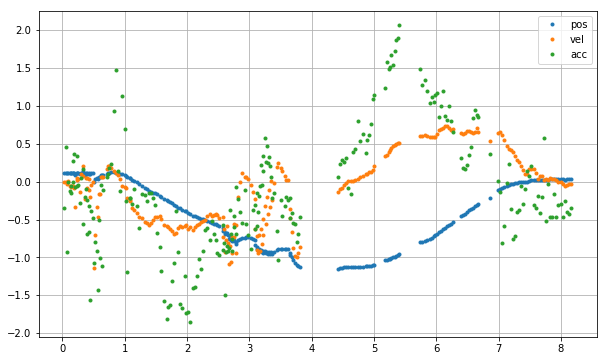

In [1360]:
plt.figure(figsize=(10,6))
plt.plot(tpos,x_est,'.')
plt.legend(['pos','vel','acc'])
plt.grid()

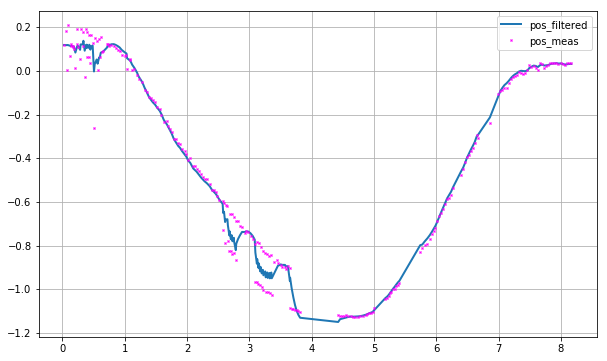

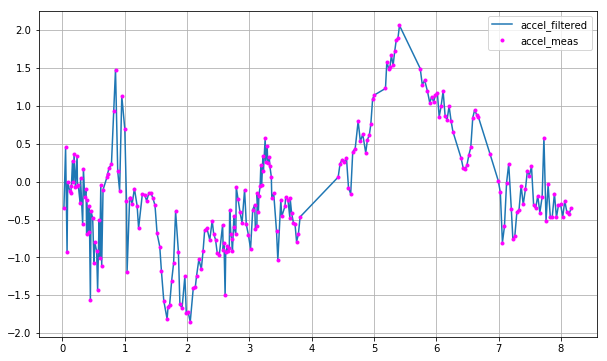

In [1361]:
plt.figure(figsize=(10,6))
plt.plot(tpos,x_est[:,0], LineWidth=2)
plt.plot(tpos,z_meas[:,0], 'x', color='magenta', MarkerSize=2)
plt.legend(['pos_filtered','pos_meas'])
plt.grid()

plt.figure(figsize=(10,6))
plt.plot(tpos,x_est[:,2])
plt.plot(tpos,z_meas[:,1], '.', color='magenta')
plt.legend(['accel_filtered','accel_meas'])
plt.grid()

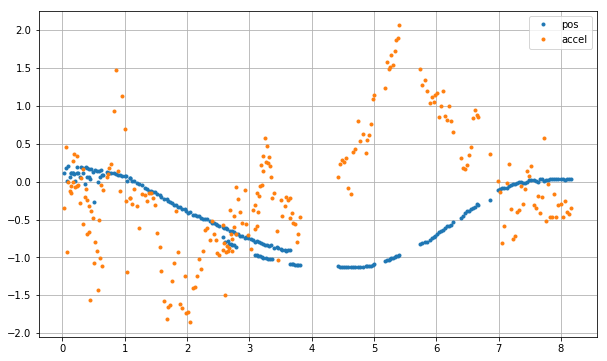

In [1362]:
plt.figure(figsize=(10,6))
plt.plot(tpos,z_meas,'.')
plt.legend(['pos','accel'])
plt.grid()

### Filter based on Standard Deviation

In [1368]:
# time derivative
def derivative(x,t):
    diff = np.zeros(x.shape[0]-1)
    for i in range(len(x)-1):
        dx = x[i+1]-x[i]
        dt = t[i+1]-t[i]
        diff[i] = dx/dt
#     diff = diff/np.pi*180
    return diff

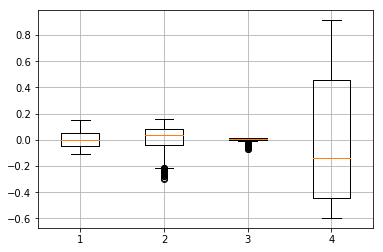

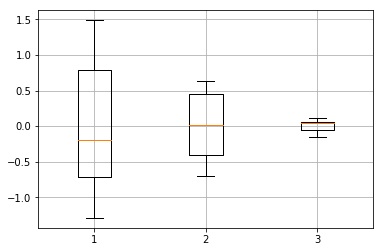

In [1369]:
plt.figure()
plt.boxplot((orientation-orient_means)[:,:])
plt.grid()

plt.figure()
plt.boxplot(position-pos_means)
plt.grid()

### Draw All clean

In [1381]:
obs = observations[0]

AB1 parallel


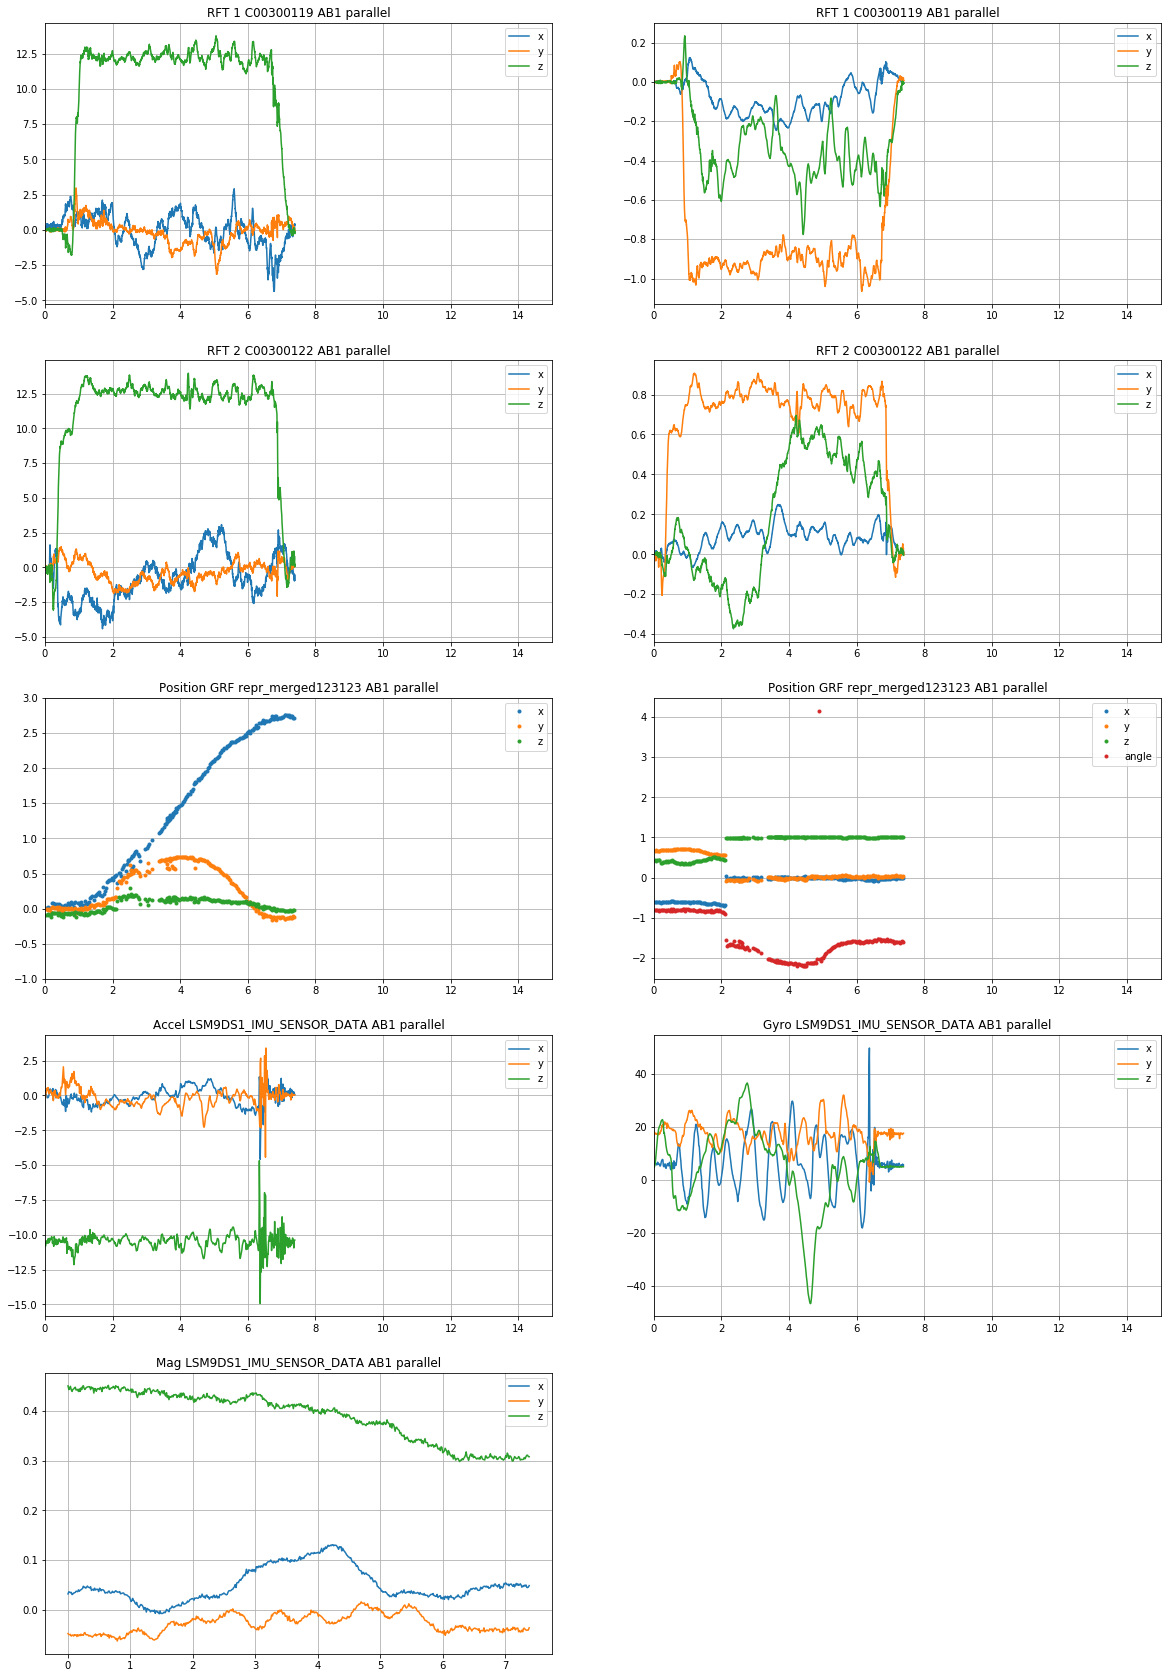

In [1382]:
plot_all_clean(observations[5])

### Draw merged position

In [22]:
obs = observations[15]

AB1 parallel


KeyError: 'pose1_grf'

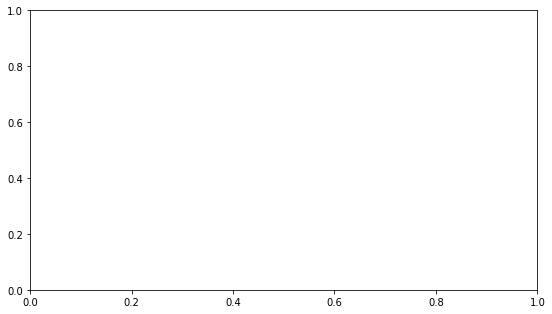

In [23]:
h = 6
w = 2
ylim = 1.5
xlim = 15

plt.figure(figsize=(20,h*6))

           
print obs['traj_type'], obs['motion_type']

# Position from camera 1
plt.subplot(h,w,1)
plt.plot(obs['pose1_grf']['time_steps'], obs['pose1_grf']['position'], '*', alpha=0.5)
plt.plot(obs['pose1_off_grf']['time_steps'], obs['pose1_off_grf']['position'], '.', alpha=0.5)
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 1 online vs offline %s'%obs['pose1_grf']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)


plt.subplot(h,w,2)
plt.plot(obs['pose1_grf']['time_steps'], obs['pose1_grf']['quaternion'], '*', alpha=0.5)
plt.plot(obs['pose1_off_grf']['time_steps'], obs['pose1_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 1 %s'%obs['pose1_grf']['frame_id'])
plt.grid()

plt.xlim(0, xlim)


# Merged
plt.subplot(h,w,3)
plt.plot(obs['pose1_merged']['time_steps'], obs['pose1_merged']['position'], '*')
plt.legend(['x','y','z'])
plt.gca().set_title('Position 1 online vs offline %s'%obs['pose1_merged']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)


plt.subplot(h,w,4)
plt.plot(obs['pose1_merged']['time_steps'], obs['pose1_merged']['quaternion'], '*', alpha=0.5)
plt.legend(['x','y','z', 'w'])
plt.gca().set_title('Quaternion 1 %s'%obs['pose1_merged']['frame_id'])
plt.grid()

plt.xlim(0, xlim)


# Position from camera 2
plt.subplot(h,w,5)
plt.plot(obs['pose2_grf']['time_steps'], obs['pose2_grf']['position'],'*', alpha=0.5)
plt.plot(obs['pose2_off_grf']['time_steps'], obs['pose2_off_grf']['position'], '.', alpha=1)
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 2 online vs offline %s'%obs['pose2_grf']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)

plt.subplot(h,w,6)
plt.plot(obs['pose2_grf']['time_steps'], obs['pose2_grf']['quaternion'],'*')
plt.plot(obs['pose2_off_grf']['time_steps'], obs['pose2_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 2 %s'%obs['pose2_grf']['frame_id'])
plt.grid()

plt.xlim(0, xlim)


# Merged
plt.subplot(h,w,7)
plt.plot(obs['pose2_merged']['time_steps'], obs['pose2_merged']['position'],'*', alpha=0.5)
plt.legend(['x','y','z'])
plt.gca().set_title('Position 2 merged %s'%obs['pose2_merged']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)

plt.subplot(h,w,8)
plt.plot(obs['pose2_merged']['time_steps'], obs['pose2_merged']['quaternion'],'*')
plt.legend(['x','y','z', 'w'])
plt.gca().set_title('Quaternion 2 %s'%obs['pose2_merged']['frame_id'])
plt.grid()

plt.xlim(0, xlim)


# Position from camera 3
plt.subplot(h,w,9)
plt.plot(obs['pose3_grf']['time_steps'], obs['pose3_grf']['position'],'*', alpha=0.5)
plt.plot(obs['pose3_off_grf']['time_steps'], obs['pose3_off_grf']['position'], '.')
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 3 online vs offline %s'%obs['pose3_grf']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)


plt.subplot(h,w,10)
plt.plot(obs['pose3_grf']['time_steps'], obs['pose3_grf']['quaternion'],'*', alpha=0.5)
plt.plot(obs['pose3_off_grf']['time_steps'], obs['pose3_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 3 %s'%obs['pose3_grf']['frame_id'])
plt.grid()
plt.xlim(0, xlim)


# Merged
plt.subplot(h,w,11)
plt.plot(obs['pose3_merged']['time_steps'], obs['pose3_merged']['position'],'*', alpha=0.5)
plt.legend(['x','y','z'])
plt.gca().set_title('Position 3 online vs offline %s'%obs['pose3_merged']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)


plt.subplot(h,w,12)
plt.plot(obs['pose3_merged']['time_steps'], obs['pose3_merged']['quaternion'],'*', alpha=0.5)
plt.legend(['x','y','z', 'w'])
plt.gca().set_title('Quaternion 3 %s'%obs['pose3_merged']['frame_id'])
plt.grid()
plt.xlim(0, xlim)

### Draw position variables

In [ ]:
obs = observations[16]

In [ ]:
h = 3
w = 2
ylim = 1.5
xlim = 18

plt.figure(figsize=(20,h*6))

           
print obs['traj_type'], obs['motion_type']

# Position from camera 1
plt.subplot(h,w,1)
plt.plot(obs['pose1_grf']['time_steps'], obs['pose1_grf']['position'], '*', alpha=0.5)
plt.plot(obs['pose1_off_grf']['time_steps'], obs['pose1_off_grf']['position'], '.', alpha=0.5)
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 1 online vs offline %s'%obs['pose1_grf']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)


plt.subplot(h,w,2)
plt.plot(obs['pose1_grf']['time_steps'], obs['pose1_grf']['quaternion'], '*', alpha=0.5)
plt.plot(obs['pose1_off_grf']['time_steps'], obs['pose1_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 1 %s'%obs['pose1_grf']['frame_id'])
plt.grid()

plt.xlim(0, xlim)


# Position from camera 2
plt.subplot(h,w,3)
plt.plot(obs['pose2_grf']['time_steps'], obs['pose2_grf']['position'],'*', alpha=0.5)
plt.plot(obs['pose2_off_grf']['time_steps'], obs['pose2_off_grf']['position'], '.', alpha=1)
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 2 online vs offline %s'%obs['pose2_grf']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)

plt.subplot(h,w,4)
plt.plot(obs['pose2_grf']['time_steps'], obs['pose2_grf']['quaternion'],'*')
plt.plot(obs['pose2_off_grf']['time_steps'], obs['pose2_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 2 %s'%obs['pose2_grf']['frame_id'])
plt.grid()

plt.xlim(0, xlim)


# Position from camera 3
plt.subplot(h,w,5)
plt.plot(obs['pose3_grf']['time_steps'], obs['pose3_grf']['position'],'*', alpha=0.5)
plt.plot(obs['pose3_off_grf']['time_steps'], obs['pose3_off_grf']['position'], '.')
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 3 online vs offline %s'%obs['pose3_grf']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)


plt.subplot(h,w,6)
plt.plot(obs['pose3_grf']['time_steps'], obs['pose3_grf']['quaternion'],'*', alpha=0.5)
plt.plot(obs['pose3_off_grf']['time_steps'], obs['pose3_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 3 %s'%obs['pose3_grf']['frame_id'])
plt.grid()
plt.xlim(0, xlim)

In [ ]:
obs['pose1_grf']['time_steps'].shape

In [ ]:
tt = np.concatenate((obs['pose1_grf']['time_steps'], obs['pose1_off_grf']['time_steps']))
pp = np.concatenate((obs['pose1_grf']['position'], obs['pose1_off_grf']['position']))
qq = np.concatenate((obs['pose1_grf']['quaternion'], obs['pose1_off_grf']['quaternion']))

In [ ]:
tt.shape, pp.shape

In [ ]:
_, indx = np.unique(tt, return_index=True)

tt = tt[indx]
pp = pp[indx]
sind = np.argsort(tt)
tt = tt[sind]

In [ ]:
tt.shape

In [ ]:
plt.plot(tt[sind],pp[sind])
plt.xlim(0,xlim)

plt.figure()
plt.plot(tt[sind],pp[sind],'.', MarkerSize=1.2)
plt.xlim(0,xlim)

plt.figure()
plt.plot(tt[sind],qq[sind],'.', MarkerSize=1.2)
plt.xlim(0,xlim)

plt.figure()
plt.plot(obs['pose1_grf']['time_steps'],obs['pose1_grf']['position'], '.', MarkerSize=1.2)
plt.xlim(0,xlim)

In [ ]:
tt.shape

### Draw all channels

In [ ]:
h = 10
w = 2

plt.figure(figsize=(20,h*10))

           
print obs['traj_type'], obs['motion_type']

# plt.title('{} {}'.format(obs['traj_type'],obs['motion_type']))

plt.subplot(h,w,1)
plt.plot(obs['rft1']['time_steps'], obs['rft1']['force'])
plt.legend(['x','y','z'])
plt.gca().set_title('RFT1 Force %s'%obs['rft1']['frame_id'])
plt.grid()

plt.subplot(h,w,2)
plt.plot(obs['rft1']['time_steps'], obs['rft1']['torque'])
plt.legend(['x','y','z'])
plt.gca().set_title('RFT1 Torque %s'%obs['rft1']['frame_id'])
plt.grid()

plt.subplot(h,w,3)
plt.plot(obs['rft2']['time_steps'], obs['rft2']['force'])
plt.legend(['x','y','z'])
plt.gca().set_title('RFT2 Force %s'%obs['rft2']['frame_id'])
plt.grid()


plt.subplot(h,w,4)
plt.plot(obs['rft2']['time_steps'], obs['rft2']['torque'])
plt.legend(['x','y','z'])
plt.gca().set_title('RFT2 Torque %s'%obs['rft2']['frame_id'])
plt.grid()


plt.subplot(h,w,5)
plt.plot(obs['imu']['time_steps'], obs['imu']['accel'])
plt.legend(['x','y','z'])
plt.gca().set_title('IMU Accel %s'%obs['imu']['frame_id'])
plt.grid()


plt.subplot(h,w,6)
plt.plot(obs['imu']['time_steps'], obs['imu']['gyro'])
plt.legend(['x','y','z'])
plt.gca().set_title('IMU Gyro %s'%obs['imu']['frame_id'])
plt.grid()

plt.subplot(h,w,7)
plt.plot(obs['imu']['time_steps'], obs['imu']['mag'])
plt.legend(['x','y','z'])
plt.gca().set_title('IMU Mag %s'%obs['imu']['frame_id'])
plt.grid()

# Position from camera 1
plt.subplot(h,w,8)
plt.plot(obs['pose1_grf']['time_steps'], obs['pose1_grf']['position'], '*')
plt.plot(obs['pose1_off_grf']['time_steps'], obs['pose1_off_grf']['position'], '.')
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 1 online vs offline %s'%obs['pose1_grf']['frame_id'])
plt.grid()


plt.subplot(h,w,9)
plt.plot(obs['pose1_grf']['time_steps'], obs['pose1_grf']['quaternion'], '*')
plt.plot(obs['pose1_off_grf']['time_steps'], obs['pose1_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 1 %s'%obs['pose1_grf']['frame_id'])
plt.grid()


# Position from camera 2
plt.subplot(h,w,10)
plt.plot(obs['pose2_grf']['time_steps'], obs['pose2_grf']['position'],'*')
plt.plot(obs['pose2_off_grf']['time_steps'], obs['pose2_off_grf']['position'], '.')
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 2 online vs offline %s'%obs['pose2_grf']['frame_id'])
plt.grid()

plt.subplot(h,w,11)
plt.plot(obs['pose2_grf']['time_steps'], obs['pose2_grf']['quaternion'],'*')
plt.plot(obs['pose2_off_grf']['time_steps'], obs['pose2_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 2 %s'%obs['pose2_grf']['frame_id'])
plt.grid()


# Position from camera 3
plt.subplot(h,w,12)
plt.plot(obs['pose3_grf']['time_steps'], obs['pose3_grf']['position'],'*')
plt.plot(obs['pose3_off_grf']['time_steps'], obs['pose3_off_grf']['position'], '.')
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 3 online vs offline %s'%obs['pose3_grf']['frame_id'])
plt.grid()


plt.subplot(h,w,13)
plt.plot(obs['pose3_grf']['time_steps'], obs['pose3_grf']['quaternion'],'*')
plt.plot(obs['pose3_off_grf']['time_steps'], obs['pose3_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 3 %s'%obs['pose3_grf']['frame_id'])
plt.grid()


In [ ]:
# all_observations = all_observations+observations

In [ ]:
# pickle.dump(all_observations, open('segmented_trials.pkl', 'w'))

In [ ]:
# pickle.dump(observations, open('segmented_trials.pkl', 'w'))